Select GPU to use

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
import os
import tensorflow as tf

# Specify the GPU you want to use (e.g., "0" for the first GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Verify TensorFlow can see the specified GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Number of Physical GPUs: {len(gpus)}, Number of Logical GPUs: {len(logical_gpus)}")
        
        # Print the name of the GPU being used
        for gpu in gpus:
            print(f"GPU Name: {gpu.name}")
            
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found.")


Number of Physical GPUs: 1, Number of Logical GPUs: 1
GPU Name: /physical_device:GPU:0


2024-07-15 00:47:39.518759: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-15 00:47:39.519070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31136 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:65:00.0, compute capability: 7.0


In [4]:
import tensorflow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13656104016662901082
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32648855552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11966336601682682729
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:65:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


2024-07-15 00:47:39.930325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /device:GPU:0 with 31136 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:65:00.0, compute capability: 7.0


Importing Libraries

In [6]:
import os
import numpy as np
from utils import datapipeline # file named datapipeline cosisting of our custom dataloader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

Initializing Data loader

In [5]:
##############################################################
#Define the image generators for training and validation
train_img_dir = "/home/abul/Downloads/input_data_128/train/images/"
train_mask_dir = "/home/abul/Downloads/input_data_128/train/masks/"

val_img_dir = "/home/abul/Downloads/input_data_128/val/images/"
val_mask_dir = "/home/abul/Downloads/input_data_128/val/masks/"

train_img_list=sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list=sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))


batch_size = 4

train_img_datagen = datapipeline.imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = datapipeline.imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

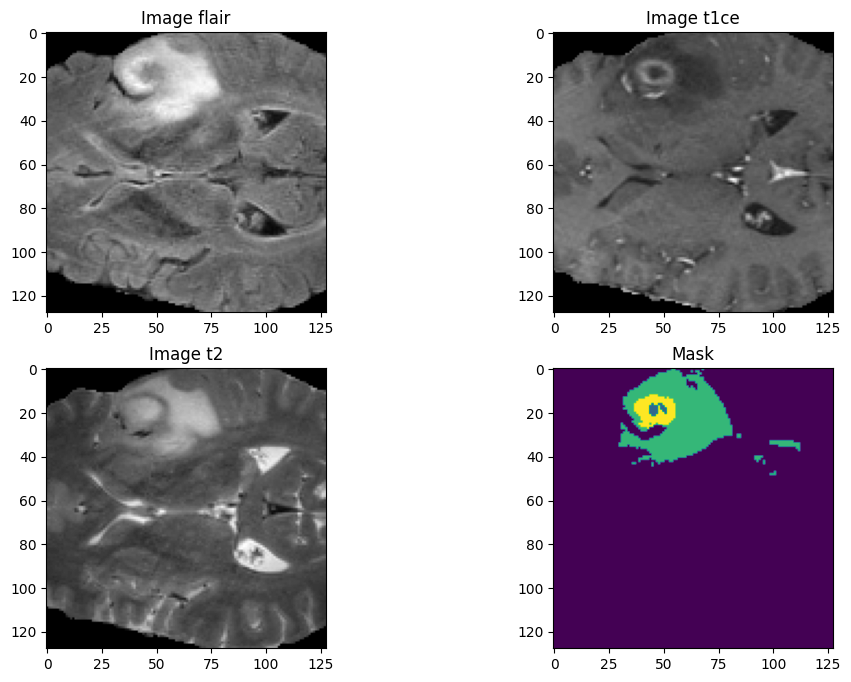

In [6]:
# Verify generator
img, msk = train_img_datagen.__next__()

img_num = int(input("Enter num of image you wan to view : ")) #only enter number in range of batch size here its 2 [0,1]
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=int(input("Enter slice number : ")) # 0 - 128 
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


Defining Loss and Optimizers

In [7]:
#Define loss, metrics and optimizer to be used for training
from utils import losses
def loss(y_true, y_pred):

    return 0.5 * losses.BCELoss(y_true, y_pred) + 0.5 * losses.TverskyLoss(losses.alpha, losses.beta)(y_true, y_pred)

# Define metrics
num_classes = 4
metrics = [
    'accuracy',
    tf.keras.metrics.MeanIoU(num_classes=num_classes),
    tf.keras.metrics.IoU(num_classes=num_classes, target_class_ids=[0, 1, 2, 3])
]

LR = 0.0001
optimizer= keras.optimizers.Adam(LR)

Initializing the model

In [15]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

from utils import UNET_V1 as UNET
model = UNET(IMG_HEIGHT=128, 
            IMG_WIDTH=128, 
            IMG_DEPTH=128, 
            IMG_CHANNELS=3, 
            num_classes=4)

model.compile(optimizer = optimizer, loss=loss, metrics=metrics)

Training

In [16]:
import tensorflow as tf
import logging
import warnings
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=UserWarning, message='The operation took')
# use model checkpoint & early stopping for better and versatile training
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/100


/home/abul/miniforge3/envs/tf/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


60/60 ━━━━━━━━━━━━━━━━━━━━ 520s 8s/step - accuracy: 0.4288 - io_u_2: 0.2919 - loss: 0.7454 - mean_io_u_2: 0.2919 - val_accuracy: 0.9472 - val_io_u_2: 0.3779 - val_loss: 0.4807 - val_mean_io_u_2: 0.3779
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9519 - io_u_2: 0.4884 - loss: 0.4270 - mean_io_u_2: 0.4884 - val_accuracy: 0.9545 - val_io_u_2: 0.4991 - val_loss: 0.3963 - val_mean_io_u_2: 0.4991
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9517 - io_u_2: 0.4947 - loss: 0.3894 - mean_io_u_2: 0.4947 - val_accuracy: 0.9537 - val_io_u_2: 0.4922 - val_loss: 0.3628 - val_mean_io_u_2: 0.4922
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9489 - io_u_2: 0.4966 - loss: 0.3758 - mean_io_u_2: 0.4966 - val_accuracy: 0.9604 - val_io_u_2: 0.4998 - val_loss: 0.3437 - val_mean_io_u_2: 0.4998
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9492 - io_u_2: 0.4970 - loss: 0.3584 - mean_io_u_2: 0.4970 - val_accuracy: 0.9544 - val_io

Saving Model Weights

In [17]:
model.save('V-1.hdf5')

Saving Results

In [19]:
import csv

# Define a list to store training results
training_results = []

# Retrieve the metric names from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
training_accuracy = history.history['accuracy']
training_iou_score = history.history['io_u_2']
training_mean_iou = history.history['mean_io_u_2']

validation_accuracy = history.history['val_accuracy']
validation_iou_score = history.history['val_io_u_2']
validation_mean_iou = history.history['val_mean_io_u_2']

# Append the training and validation results to the list
for epoch, train_acc, train_iou, train_mean_iou, val_acc, val_iou, val_mean_iou in zip(
    epochs, training_accuracy, training_iou_score, training_mean_iou, validation_accuracy, validation_iou_score, validation_mean_iou
):
    training_results.append([
        epoch, train_acc, train_iou, train_mean_iou, val_acc, val_iou, val_mean_iou
    ])

# Define the training CSV file path
training_csv_file = 'training_and_val_metrics.csv'

# Write the training and validation results to a CSV file
with open(training_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        'Epoch', 'Training Accuracy', 'Training IOU Score', 'Training Mean IOU', 
        'Validation Accuracy', 'Validation IOU Score', 'Validation Mean IOU'
    ])
    writer.writerows(training_results)

print(f'Training results saved to {training_csv_file}')


Training results saved to training_and_val_metrics.csv


In [20]:
import pandas as pd
df = pd.read_csv(training_csv_file)
print(df)

    Epoch  Training Accuracy  Training IOU Score  Training Mean IOU  \
0       1           0.686913            0.498696           0.498696   
1       2           0.951221            0.493412           0.493412   
2       3           0.947985            0.490686           0.490686   
3       4           0.948099            0.493325           0.493325   
4       5           0.949406            0.494764           0.494764   
..    ...                ...                 ...                ...   
95     96           0.988857            0.499014           0.499014   
96     97           0.988773            0.499207           0.499207   
97     98           0.988634            0.499177           0.499177   
98     99           0.988367            0.499170           0.499170   
99    100           0.988788            0.499203           0.499203   

    Validation Accuracy  Validation IOU Score  Validation Mean IOU  
0              0.947234              0.377883             0.377883  
1        

Testing

In [22]:
test_img_dir = "/home/abul/Downloads/input_data_128/test/images/"
test_mask_dir = "/home/abul/Downloads/input_data_128/test/masks/"

test_img_list = sorted(os.listdir(test_img_dir))
test_mask_list = sorted(os.listdir(test_mask_dir))

batch_size=2
test_img_datagen = datapipeline.imageLoader(test_img_dir, test_img_list,  test_mask_dir, test_mask_list, batch_size)
test_steps_per_epoch =(len(test_img_list)//batch_size )+1 

test_loss, test_accuracy, iou, mean_iou = model.evaluate(
    test_img_datagen, 
    steps = test_steps_per_epoch, 
    verbose=1
)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test IoU Score: {iou}')
print(f'Test Mean IoU: {mean_iou}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9767 - io_u_2: 0.5668 - loss: 0.1268 - mean_io_u_2: 0.5668
Test Loss: 0.15103209018707275
Test Accuracy: 0.9737195372581482
Test IoU Score: 0.4994560480117798
Test Mean IoU: 0.4994560480117798


In [23]:
def dice_score(o, t, eps=1e-8):
    num = 2*(o*t).sum() + eps
    den = o.sum() + t.sum() + eps
    return num/den

def softmax_output_dice(target,output):
    ret = []
    
    # whole   wt
    o = output > 0; t = target > 0 # ce
    ret += dice_score(o, t),
    
    # core   tc
    o = (output == 1) | (output == 3)
    t = (target == 1) | (target == 3)
    ret += dice_score(o, t),
    
    # active   et
    o = (output == 3);t = (target == 3)
    ret += dice_score(o, t),

    return ret


dice_scores_wt = []
dice_scores_tc = []
dice_scores_et = []
num_classes = 4

for batch in range(test_steps_per_epoch):
    
    test_img, test_mask = next(test_img_datagen)
    test_prediction = model.predict(test_img)
    
    test_mask_argmax=np.argmax(test_mask, axis=4)[0,:,:,:]
    test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]
    
    tensor = softmax_output_dice(test_mask_argmax, test_prediction_argmax)
    dice_batch = tensor[0]
    dice_scores_wt.append(dice_batch)
    dice_scores_tc.append(tensor[1])
    dice_scores_et.append(tensor[2])


print("Dice Scores for Unet trained for 100 epochs with dice loss : ")
average_dice_score_et = sum(dice_scores_et) / len(dice_scores_et)
print("Average Dice Score et:", average_dice_score_et)
average_dice_score_wt = sum(dice_scores_wt) / len(dice_scores_wt)
print("Average Dice Score wt:", average_dice_score_wt)
average_dice_score_tc = sum(dice_scores_tc) / len(dice_scores_tc)
print("Average Dice Score tc:", average_dice_score_tc)



import csv

# Define the test results
average_dice_scores = [
    ['Enhanced Tumor', average_dice_score_et],
    ['Whole Tumor', average_dice_score_wt],
    ['Tumor Core', average_dice_score_tc]
]

# Define the CSV file path
test_csv_file = 'dice_scores.csv'

# Write the test results to a CSV file
with open(test_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(average_dice_scores)

print(f'dice scores results saved to {test_csv_file}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━

In [24]:
import pandas as pd
df = pd.read_csv(test_csv_file)
print(df)

  Enhanced Tumor  0.639473802868928
0    Whole Tumor           0.810919
1     Tumor Core           0.745247


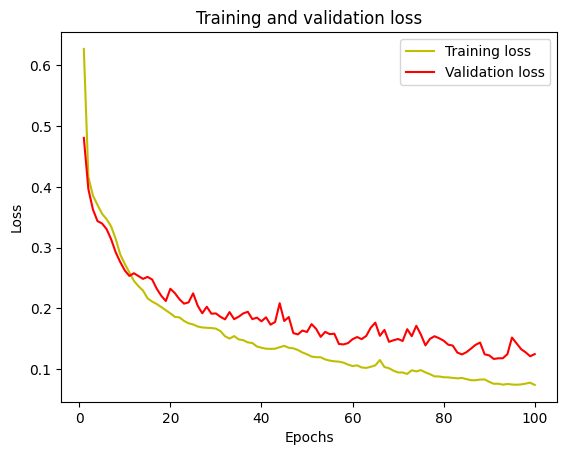

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Loading Model for testing

In [8]:
import tensorflow as tf
from keras.losses import Loss
from keras.utils import get_custom_objects
from keras.models import load_model
get_custom_objects().update({"loss": loss})
get_custom_objects().update({"io_u_2": tf.keras.metrics.IoU(num_classes=num_classes, target_class_ids=[0, 1, 2, 3])})
get_custom_objects().update({"mean_io_u_2": tf.keras.metrics.MeanIoU(num_classes=4)})   
my_model = load_model('V-1.hdf5')

Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(128, 128, 128)
(128, 128, 128)
[0 1 2 3]
[0 1 2 3]


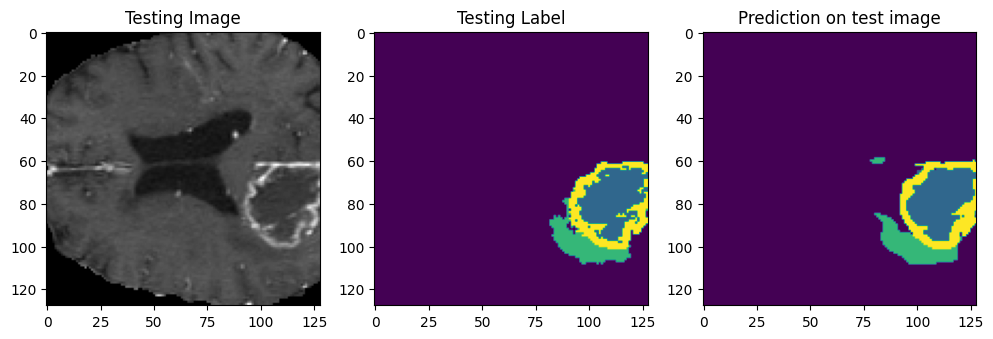

In [11]:
img_num = 41
test_img = np.load("/home/abul/Downloads/input_data_128/test/images/image_"+str(img_num)+".npy")
test_mask = np.load("/home/abul/Downloads/input_data_128/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

n_slice=int(input("Enter slice number to view : "))
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()